# 01 - Introducción a NLP y Embeddings Básicos

## Curso de LLMs y Aplicaciones de IA

**Duración estimada:** 2-2.5 horas

---

## Índice

1. [Introducción a NLP y Vectorización](#intro)
2. [One-Hot Encoding](#onehot)
   - 2.1 Implementación con Scikit-Learn
   - 2.2 Implementación con Keras
3. [Word2Vec](#word2vec)
   - 3.1 Entrenando un modelo propio
   - 3.2 Modelos pre-entrenados (Google News, GloVe)
   - 3.3 Creando matrices de embedding
4. [Visualización con PCA](#pca)
5. [Ejercicios prácticos](#ejercicios)

---

## Objetivos de aprendizaje

Al finalizar este notebook, serás capaz de:
- Comprender qué son los embeddings y por qué son fundamentales en NLP
- Implementar One-Hot Encoding de diferentes maneras
- Entrenar y utilizar modelos Word2Vec
- Visualizar embeddings en espacios de menor dimensión
- Entender las limitaciones de estos métodos clásicos

<a name="intro"></a>
## 1. Introducción a NLP y Vectorización

### ¿Qué es la vectorización de palabras?

La **vectorización de palabras** (Word Embeddings) consiste en obtener un vector numérico que represente las características semánticas de una palabra. Esta representación permite:

- Realizar operaciones matemáticas entre palabras
- Capturar relaciones semánticas ("rey" - "hombre" + "mujer" ≈ "reina")
- Medir similitud entre palabras
- Alimentar modelos de Machine Learning y Deep Learning

### La hipótesis distribucional

El fundamento teórico de los embeddings es la **hipótesis distribucional**: 
> "Las palabras que aparecen en contextos similares tienden a tener significados similares."

Por ejemplo, "perro" y "gato" aparecen frecuentemente en contextos similares ("mi mascota es un...", "el ... corre por el jardín"), por lo que sus vectores deberían estar cercanos en el espacio vectorial.

### Evolución histórica

| Método | Año | Características |
|--------|-----|----------------|
| One-Hot | Clásico | Vectores sparse, sin semántica |
| TF-IDF | Clásico | Frecuencia de términos ponderada |
| Word2Vec | 2013 | Vectores densos, captura semántica |
| GloVe | 2014 | Combina co-ocurrencia global y local |
| FastText | 2016 | Subpalabras, mejor para palabras raras |
| BERT | 2018 | Contextuales y bidireccionales |

## Instalación de dependencias

Ejecuta esta celda para instalar las librerías necesarias. Estas librerías son **gratuitas** y no requieren API keys.

In [1]:
# Install required libraries (all free and open source)
!pip install -q gensim==4.3.2 smart_open==6.4.0
!pip install -q spacy scikit-learn matplotlib seaborn
!python -m spacy download es_core_news_sm -q
!python -m spacy download en_core_web_sm -q

[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

C:\Users\frane\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<a name="onehot"></a>
## 2. One-Hot Encoding

### ¿Qué es One-Hot Encoding?

One-Hot Encoding es la forma más simple de representar palabras como vectores. Cada palabra se representa como un vector binario donde:
- Solo una posición tiene valor 1 (la que corresponde a esa palabra)
- Todas las demás posiciones tienen valor 0

**Ejemplo con un vocabulario de 4 ciudades:**
- Madrid = [1, 0, 0, 0]
- Barcelona = [0, 1, 0, 0]
- Sevilla = [0, 0, 1, 0]
- Valencia = [0, 0, 0, 1]

### Ventajas y desventajas

| Ventajas | Desventajas |
|----------|-------------|
| Simple de implementar | No captura semántica |
| Sin pérdida de información | Vectores muy grandes (dimensión = vocabulario) |
| Útil para categorías | Todas las palabras equidistantes |

### 2.1 Preparación del texto

Vamos a trabajar con un fragmento del Quijote para demostrar One-Hot Encoding.

In [3]:
# Sample text from Don Quixote (first paragraph)
quijote_raw = """
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, 
no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, 
adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, 
salpicón las más noches, duelos y quebrantos los sábados, 
lentejas los viernes, algún palomino de añadidura los domingos, 
consumían las tres partes de su hacienda.
"""

print("Texto original:")
print(quijote_raw)

Texto original:

En un lugar de la Mancha, de cuyo nombre no quiero acordarme, 
no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, 
adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, 
salpicón las más noches, duelos y quebrantos los sábados, 
lentejas los viernes, algún palomino de añadidura los domingos, 
consumían las tres partes de su hacienda.



In [4]:
import spacy

# Load Spanish model (disable unnecessary components for speed)
nlp = spacy.load("es_core_news_sm", disable=['tagger', 'parser', 'ner'])

# Process and clean text
quijote_clean = []
doc = nlp(quijote_raw)

# Simple cleaning:
#   1. Remove punctuation
#   2. Remove stop words
#   3. Remove whitespace
#   4. Convert to lowercase lemmas
for token in doc:
    if not (token.is_punct or token.is_stop or token.is_space):
        quijote_clean.append(token.lemma_.lower())

print(f"Tokens limpios ({len(quijote_clean)}):")
print(quijote_clean)

Tokens limpios (33):
['lugar', 'mancha', 'cuyo', 'nombre', 'querer', 'acordar yo', 'tiempo', 'vivir', 'hidalgo', 'lanza', 'astillero', 'adarga', 'antiguo', 'rocín', 'flaco', 'galgo', 'corredor', 'olla', 'vaco', 'carnero', 'salpicón', 'noche', 'duelo', 'quebranto', 'sábado', 'lenteja', 'viernes', 'palomino', 'añadidura', 'domingo', 'consumir', 'parte', 'hacienda']


### 2.2 One-Hot con Scikit-Learn

In [5]:
from sklearn import preprocessing

# Convert tokens to array (each token as a separate list)
arr_text = np.array([quijote_clean]).reshape(-1, 1)
print(f"Shape del array: {arr_text.shape}")
print(f"Primeros 5 tokens: {arr_text[:5].flatten()}")

Shape del array: (33, 1)
Primeros 5 tokens: ['lugar' 'mancha' 'cuyo' 'nombre' 'querer']


In [6]:
# Apply OneHotEncoder
word_encoder = preprocessing.OneHotEncoder()
onehot_matrix = word_encoder.fit_transform(arr_text)

# Get unique words (vocabulary)
vocabulary = word_encoder.categories_[0]
print(f"Número de palabras únicas (vocabulario): {len(vocabulary)}")
print(f"\nVocabulario: {list(vocabulary)}")

Número de palabras únicas (vocabulario): 33

Vocabulario: ['acordar yo', 'adarga', 'antiguo', 'astillero', 'añadidura', 'carnero', 'consumir', 'corredor', 'cuyo', 'domingo', 'duelo', 'flaco', 'galgo', 'hacienda', 'hidalgo', 'lanza', 'lenteja', 'lugar', 'mancha', 'noche', 'nombre', 'olla', 'palomino', 'parte', 'quebranto', 'querer', 'rocín', 'salpicón', 'sábado', 'tiempo', 'vaco', 'viernes', 'vivir']


In [7]:
# View the sparse matrix as dense array
print("Matriz One-Hot (primeras 5 filas):")
print(onehot_matrix.toarray()[:5])

Matriz One-Hot (primeras 5 filas):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
# Get specific word from vector
first_vector = onehot_matrix.toarray()[0]
word_index = first_vector.argmax()
word = vocabulary[word_index]

print(f"Primer vector: {first_vector}")
print(f"Posición del 1: {word_index}")
print(f"Palabra correspondiente: '{word}'")

Primer vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Posición del 1: 17
Palabra correspondiente: 'lugar'


### 2.3 One-Hot con TensorFlow/Keras

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Create tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(quijote_clean)

# Generate one-hot matrix
keras_onehot = tokenizer.texts_to_matrix(quijote_clean)

print(f"Shape de la matriz Keras: {keras_onehot.shape}")

Shape de la matriz Keras: (33, 35)


In [10]:
# Check first vector
first_keras = keras_onehot[0]
word_idx = np.argmax(first_keras)
word = tokenizer.index_word[word_idx]

print(f"Primera palabra: '{word}'")
print(f"Índice en el vocabulario: {word_idx}")

Primera palabra: 'lugar'
Índice en el vocabulario: 1


### Limitaciones de One-Hot Encoding

**Problema de dimensionalidad:**
- Para un vocabulario de 100,000 palabras, cada vector tiene 100,000 dimensiones
- La mayoría de valores son ceros (vectores sparse)

**Problema semántico:**
- "perro" y "gato" están a la misma distancia que "perro" y "avión"
- No captura ninguna relación semántica

Por estas razones, necesitamos métodos más sofisticados como **Word2Vec**.

<a name="word2vec"></a>
## 3. Word2Vec

### ¿Qué es Word2Vec?

**Word2Vec** (Word to Vector) es un algoritmo desarrollado por Google en 2013 que genera **vectores densos** de dimensión fija (típicamente 100-300) que capturan relaciones semánticas entre palabras.

### Arquitecturas de Word2Vec

| CBOW (Continuous Bag of Words) | Skip-gram |
|-------------------------------|----------|
| Predice palabra objetivo desde contexto | Predice contexto desde palabra objetivo |
| Más rápido de entrenar | Mejor para palabras raras |
| Mejor para corpus grandes | Mejor para corpus pequeños |

### Parámetros importantes

- **vector_size**: Dimensión del vector resultante (100-300 típico)
- **window**: Número de palabras de contexto a considerar
- **min_count**: Frecuencia mínima para incluir una palabra
- **workers**: Número de CPU cores a usar

### 3.1 Entrenando un modelo Word2Vec propio

Vamos a entrenar un modelo con un texto literario. Para esto usaremos fragmentos de texto en español.

In [11]:
# Sample Spanish text for training (extended Don Quixote excerpt)
spanish_text = """
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo 
que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor.
Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados,
lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda.
El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo,
los días de entre semana se honraba con su vellori de lo más fino.
Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte,
y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera.
Frisaba la edad de nuestro hidalgo con los cincuenta años, era de complexión recia, seco de carnes,
enjuto de rostro; gran madrugador y amigo de la caza.
Quieren decir que tenía el sobrenombre de Quijada o Quesada, aunque por conjeturas verosímiles
se deja entender que se llama Quijana; pero esto importa poco a nuestro cuento;
basta que en la narración dél no se salga un punto de la verdad.
Es, pues, de saber, que este sobredicho hidalgo, los ratos que estaba ocioso,
que eran los más del año, se daba a leer libros de caballerías con tanta afición y gusto,
que olvidó casi de todo punto el ejercicio de la caza, y aun la administración de su hacienda.
Y llegó a tanto su curiosidad y desatino en esto, que vendió muchas hanegas de tierra de sembradura,
para comprar libros de caballerías en que leer; y así llevó a su casa todos cuantos pudo haber dellos.
El amor es locura, y la locura es amor.
La libertad es uno de los más preciosos dones que a los hombres dieron los cielos.
El que no sabe gozar de la ventura cuando le viene, no debe quejarse si se le pasa.
Cada uno es artífice de su ventura. La pluma es la lengua del alma.
El valor está en el alma, no en el cuerpo.
Sé breve en tus razonamientos, que ninguno hay gustoso si es largo.
"""

print(f"Longitud del texto: {len(spanish_text)} caracteres")

Longitud del texto: 1981 caracteres


In [12]:
def clean_text_for_w2v(text, nlp):
    """
    Clean text with spaCy for Word2Vec training.
    Returns list of lists of lemmas (sentences).
    
    Parameters:
    - text: string with full text
    - nlp: loaded spaCy model
    
    Returns:
    - List of lists of clean lemmas
    """
    clean_sentences = []
    
    for line in text.split("\n"):
        doc = nlp(line)
        lemmas = [
            token.lemma_.lower()
            for token in doc
            if not (token.is_punct or token.is_stop or token.is_space)
        ]
        if lemmas:  # Only add if there are useful tokens
            clean_sentences.append(lemmas)
    
    return clean_sentences

# Process text
clean_sentences = clean_text_for_w2v(spanish_text, nlp)
print(f"Número de oraciones: {len(clean_sentences)}")
print(f"\nPrimeras 3 oraciones:")
for i, sent in enumerate(clean_sentences[:3]):
    print(f"  {i+1}: {sent}")

Número de oraciones: 24

Primeras 3 oraciones:
  1: ['lugar', 'mancha', 'cuyo', 'nombre', 'querer', 'acordar yo', 'tiempo']
  2: ['vivir', 'hidalgo', 'lanza', 'astillero', 'adarga', 'antiguo', 'rocín', 'flaco', 'galgo', 'corredor']
  3: ['olla', 'vaco', 'carnero', 'salpicón', 'noche', 'duelo', 'quebranto', 'sábado']


In [13]:
from gensim.models import Word2Vec
import multiprocessing

# Get number of available cores
num_cores = multiprocessing.cpu_count()
print(f"Número de cores disponibles: {num_cores}")

# Train Word2Vec model
model_w2v = Word2Vec(
    sentences=clean_sentences,  # Training data
    vector_size=100,            # Embedding dimension
    window=5,                   # Context window size
    min_count=1,                # Minimum word frequency (1 for small corpus)
    workers=num_cores,          # Parallel processing
    epochs=100                  # Training iterations
)

print(f"\nVocabulario entrenado: {len(model_w2v.wv)} palabras")

Número de cores disponibles: 20

Vocabulario entrenado: 129 palabras


In [14]:
# Find similar words
if 'amor' in model_w2v.wv:
    print("Palabras más similares a 'amor':")
    for word, score in model_w2v.wv.most_similar("amor", topn=5):
        print(f"  {word}: {score:.4f}")
else:
    print("'amor' no está en el vocabulario")

Palabras más similares a 'amor':
  veinte: 0.3899
  campo: 0.3542
  vivir: 0.3036
  olvidar: 0.2638
  calza: 0.2601


In [15]:
# Get vector for a word
sample_word = "hidalgo"
if sample_word in model_w2v.wv:
    vector = model_w2v.wv[sample_word]
    print(f"Vector para '{sample_word}':")
    print(f"  Dimensiones: {len(vector)}")
    print(f"  Primeros 10 valores: {vector[:10]}")

Vector para 'hidalgo':
  Dimensiones: 100
  Primeros 10 valores: [ 0.00064725  0.00292671  0.00454959  0.00852907 -0.00752556 -0.0134915
  0.0093828   0.0172768  -0.00702292 -0.00756505]


### 3.2 Usando modelos pre-entrenados: GloVe

Para obtener embeddings de mayor calidad, es mejor usar modelos pre-entrenados en corpus masivos. **GloVe** (Global Vectors) fue entrenado en Wikipedia y tiene modelos de diferentes tamaños.

**Nota:** Para este ejemplo, simularemos el uso de GloVe. En producción, descarga el modelo desde: https://nlp.stanford.edu/projects/glove/

In [16]:
# For demonstration, we'll use gensim's built-in downloader
# This downloads a smaller pre-trained model
import gensim.downloader as api

print("Descargando modelo pre-entrenado (glove-wiki-gigaword-50)...")
print("Este es un modelo pequeño (50 dimensiones) para demostración.")
print("En producción, use modelos de 100-300 dimensiones.")

# Download small GloVe model (50 dimensions, ~66MB)
glove_model = api.load("glove-wiki-gigaword-50")
print(f"\nModelo cargado: {len(glove_model)} palabras")

Descargando modelo pre-entrenado (glove-wiki-gigaword-50)...
Este es un modelo pequeño (50 dimensiones) para demostración.
En producción, use modelos de 100-300 dimensiones.
[==================================================] 100.0% 66.0/66.0MB downloaded

Modelo cargado: 400000 palabras


In [17]:
# Famous Word2Vec analogy: king - man + woman = queen
result = glove_model.most_similar(
    positive=['woman', 'king'], 
    negative=['man'], 
    topn=3
)
print("Analogía: king - man + woman = ?")
for word, score in result:
    print(f"  {word}: {score:.4f}")

Analogía: king - man + woman = ?
  queen: 0.8524
  throne: 0.7664
  prince: 0.7592


In [18]:
# Geographic analogy: Paris - France + Italy = ?
result = glove_model.most_similar(
    positive=['paris', 'italy'], 
    negative=['france'], 
    topn=3
)
print("Analogía: paris - france + italy = ?")
for word, score in result:
    print(f"  {word}: {score:.4f}")

Analogía: paris - france + italy = ?
  rome: 0.8466
  milan: 0.7766
  turin: 0.7666


In [19]:
# Compute similarity between words
pairs = [
    ('dog', 'cat'),
    ('dog', 'car'),
    ('happy', 'sad'),
    ('king', 'queen')
]

print("Similitud coseno entre pares de palabras:")
for w1, w2 in pairs:
    similarity = glove_model.similarity(w1, w2)
    print(f"  {w1} <-> {w2}: {similarity:.4f}")

Similitud coseno entre pares de palabras:
  dog <-> cat: 0.9218
  dog <-> car: 0.4645
  happy <-> sad: 0.6891
  king <-> queen: 0.7839


### 3.3 Creando una matriz de embedding

Cuando construimos modelos de Deep Learning para NLP, necesitamos crear una **matriz de embedding** que mapee el índice de cada palabra a su vector correspondiente.

In [20]:
def create_embedding_matrix(word_index, pretrained_model, embedding_dim):
    """
    Create embedding matrix from pretrained model.
    
    Parameters:
    - word_index: dict mapping words to indices
    - pretrained_model: gensim KeyedVectors model
    - embedding_dim: dimension of embeddings
    
    Returns:
    - embedding_matrix: numpy array of shape (vocab_size, embedding_dim)
    """
    vocab_size = len(word_index) + 1  # +1 for padding token at index 0
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    found = 0
    not_found = 0
    
    for word, idx in word_index.items():
        if word in pretrained_model:
            embedding_matrix[idx] = pretrained_model[word]
            found += 1
        else:
            not_found += 1
    
    print(f"Palabras encontradas: {found}")
    print(f"Palabras no encontradas: {not_found}")
    
    return embedding_matrix

# Create sample word index
sample_words = ['king', 'queen', 'man', 'woman', 'paris', 'france', 'dog', 'cat']
word_index = {word: idx+1 for idx, word in enumerate(sample_words)}  # Start from 1, leave 0 for padding

print(f"Word index: {word_index}")

# Create embedding matrix
embedding_matrix = create_embedding_matrix(word_index, glove_model, embedding_dim=50)
print(f"\nMatriz de embedding shape: {embedding_matrix.shape}")

Word index: {'king': 1, 'queen': 2, 'man': 3, 'woman': 4, 'paris': 5, 'france': 6, 'dog': 7, 'cat': 8}
Palabras encontradas: 8
Palabras no encontradas: 0

Matriz de embedding shape: (9, 50)


<a name="pca"></a>
## 4. Visualización con PCA

Para visualizar los embeddings de alta dimensión, usamos **PCA** (Principal Component Analysis) para reducir a 2 o 3 dimensiones.

In [21]:
from sklearn.decomposition import PCA

# Select words for visualization
words_to_plot = [
    'king', 'queen', 'prince', 'princess',
    'man', 'woman', 'boy', 'girl',
    'dog', 'cat', 'horse', 'cow',
    'car', 'bus', 'train', 'plane',
    'happy', 'sad', 'angry', 'calm'
]

# Filter words that exist in model
words_available = [w for w in words_to_plot if w in glove_model]
vectors = np.array([glove_model[w] for w in words_available])

print(f"Palabras para visualizar: {len(words_available)}")

Palabras para visualizar: 20


In [22]:
# Apply PCA
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

print(f"Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}")

Varianza explicada: 39.75%


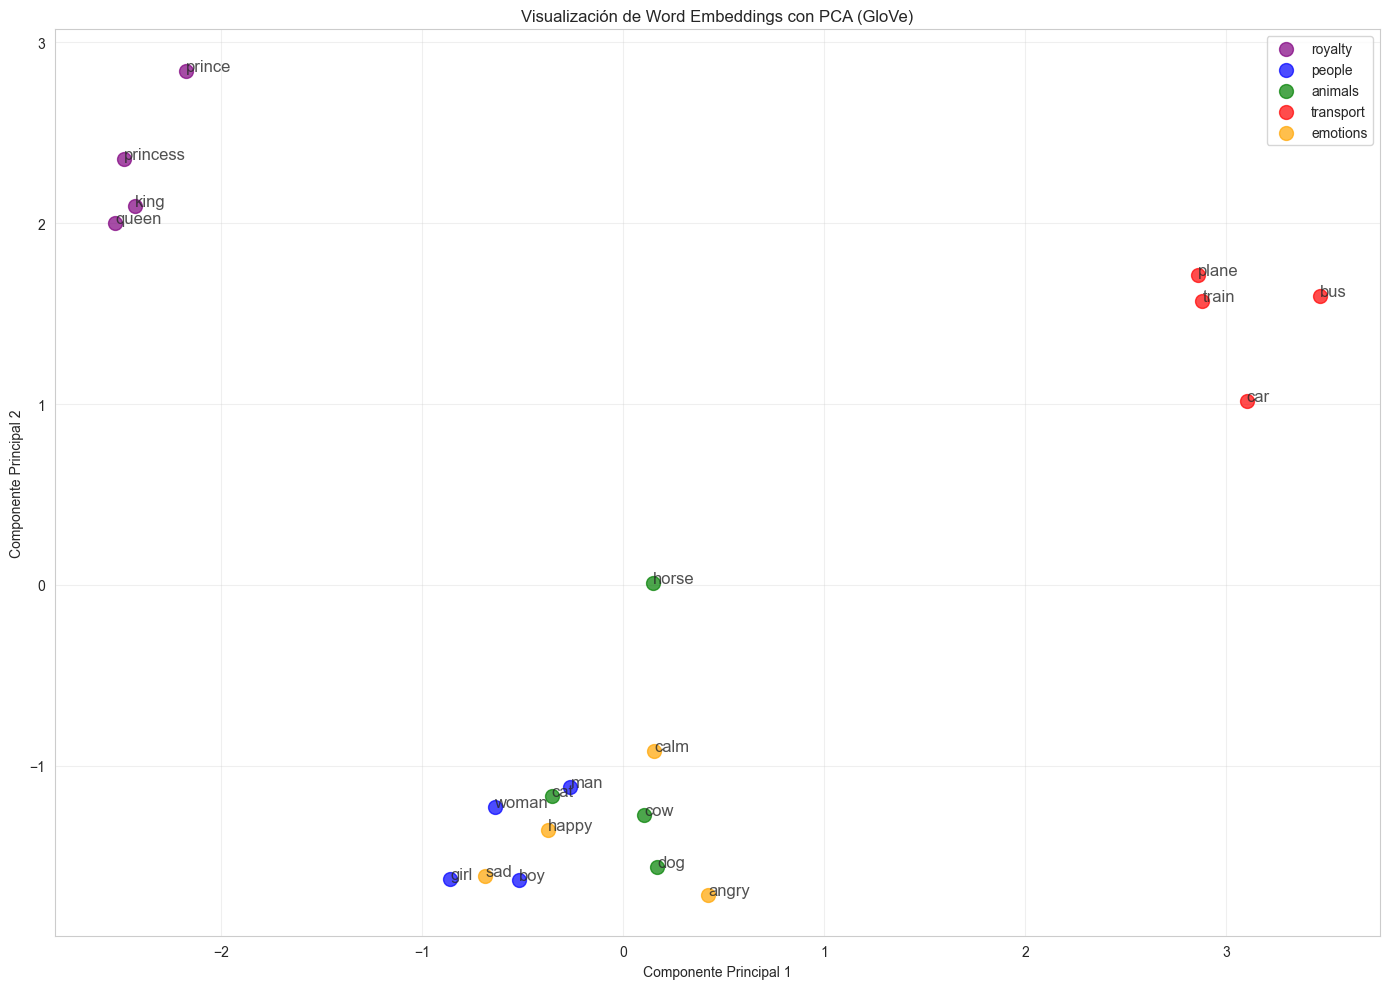

In [23]:
# Visualize
plt.figure(figsize=(14, 10))

# Define color categories
categories = {
    'royalty': ['king', 'queen', 'prince', 'princess'],
    'people': ['man', 'woman', 'boy', 'girl'],
    'animals': ['dog', 'cat', 'horse', 'cow'],
    'transport': ['car', 'bus', 'train', 'plane'],
    'emotions': ['happy', 'sad', 'angry', 'calm']
}

colors = {'royalty': 'purple', 'people': 'blue', 'animals': 'green', 
          'transport': 'red', 'emotions': 'orange'}

# Plot each category
for cat, words in categories.items():
    indices = [words_available.index(w) for w in words if w in words_available]
    if indices:
        plt.scatter(vectors_2d[indices, 0], vectors_2d[indices, 1], 
                   c=colors[cat], label=cat, s=100, alpha=0.7)

# Add word labels
for i, word in enumerate(words_available):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), 
                fontsize=12, alpha=0.8)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Word Embeddings con PCA (GloVe)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Observaciones de la visualización

En el gráfico podemos observar:
- Las palabras de una misma categoría tienden a agruparse
- Los vectores capturan relaciones semánticas
- PCA pierde información (no explica el 100% de la varianza)

Para visualizaciones más precisas, considera usar **t-SNE** o **UMAP** (veremos UMAP en el siguiente notebook).

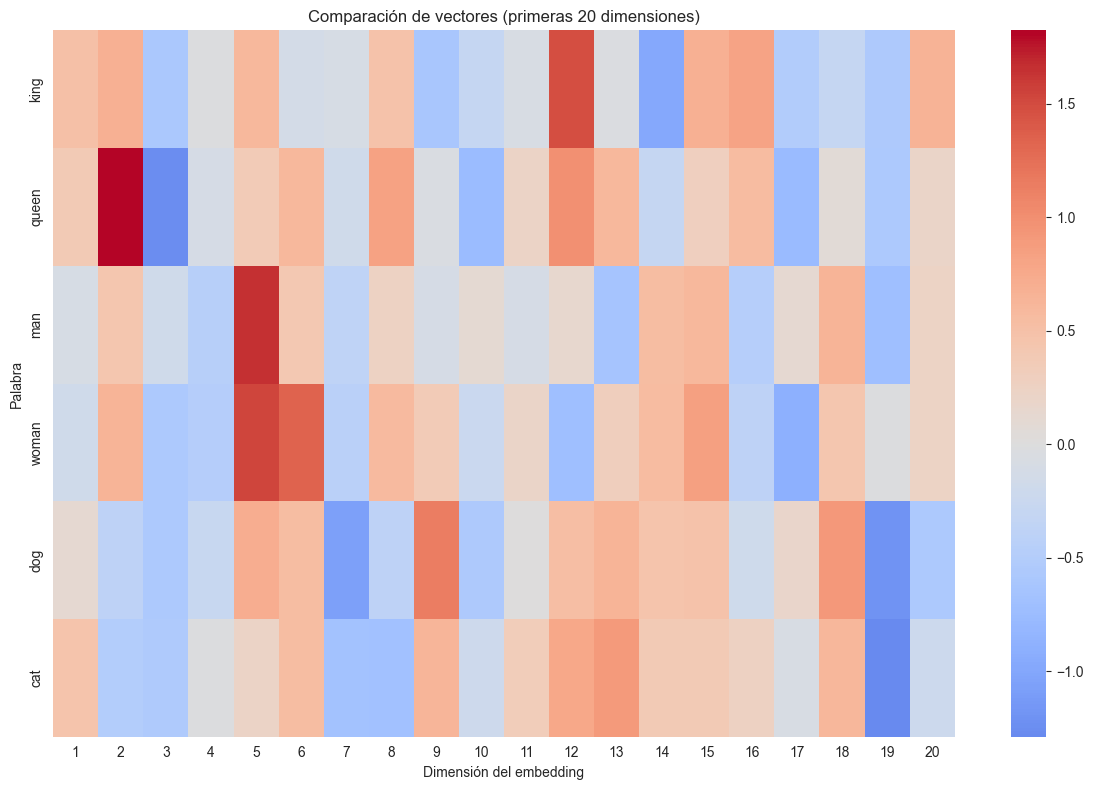

In [24]:
# Heatmap comparison of embeddings
fig, ax = plt.subplots(figsize=(12, 8))

# Select subset of words and their vectors (first 20 dimensions)
words_heat = ['king', 'queen', 'man', 'woman', 'dog', 'cat']
vectors_heat = np.array([glove_model[w][:20] for w in words_heat])

sns.heatmap(vectors_heat, cmap="coolwarm", center=0,
            yticklabels=words_heat, 
            xticklabels=range(1, 21))
plt.xlabel('Dimensión del embedding')
plt.ylabel('Palabra')
plt.title('Comparación de vectores (primeras 20 dimensiones)')
plt.tight_layout()
plt.show()

<a name="ejercicios"></a>
## 5. Ejercicios Prácticos

### Ejercicio 1: Explorar analogías
Prueba diferentes analogías con el modelo GloVe.

In [25]:
# Exercise 1: Try your own analogies
# Example: doctor - man + woman = ?

def word_analogy(model, positive, negative):
    """Find word analogies: positive[0] - negative[0] + positive[1] = ?"""
    try:
        result = model.most_similar(positive=positive, negative=negative, topn=3)
        print(f"Analogía: {positive[0]} - {negative[0]} + {positive[1]} = ?")
        for word, score in result:
            print(f"  {word}: {score:.4f}")
    except KeyError as e:
        print(f"Error: palabra no encontrada - {e}")

# Try these analogies
word_analogy(glove_model, ['woman', 'doctor'], ['man'])
print()
word_analogy(glove_model, ['berlin', 'france'], ['germany'])
print()
word_analogy(glove_model, ['smaller', 'big'], ['small'])

Analogía: woman - man + doctor = ?
  nurse: 0.8405
  child: 0.7663
  pregnant: 0.7570

Analogía: berlin - germany + france = ?
  paris: 0.9169
  prohertrib: 0.7950
  brussels: 0.7606

Analogía: smaller - small + big = ?
  bigger: 0.8704
  competitors: 0.7595
  lose: 0.7433


### Ejercicio 2: Encontrar la palabra que no encaja

In [26]:
# Exercise 2: Find the odd one out
word_lists = [
    ['dog', 'cat', 'horse', 'car'],
    ['paris', 'london', 'berlin', 'mountain'],
    ['happy', 'sad', 'angry', 'table']
]

print("Encontrar la palabra que no encaja:")
for words in word_lists:
    odd_one = glove_model.doesnt_match(words)
    print(f"  {words} -> '{odd_one}'")

Encontrar la palabra que no encaja:
  ['dog', 'cat', 'horse', 'car'] -> 'car'
  ['paris', 'london', 'berlin', 'mountain'] -> 'mountain'
  ['happy', 'sad', 'angry', 'table'] -> 'table'


### Ejercicio 3: Entrenar tu propio modelo
Modifica los parámetros del modelo Word2Vec y observa los cambios.

In [27]:
# Exercise 3: Experiment with Word2Vec parameters
# Try changing: vector_size, window, min_count, epochs

# Your code here:
# model_experiment = Word2Vec(
#     sentences=clean_sentences,
#     vector_size=???,  # Try 50, 100, 200
#     window=???,       # Try 3, 5, 10
#     min_count=???,    # Try 1, 2, 5
#     epochs=???        # Try 50, 100, 200
# )

## Resumen

En este notebook hemos aprendido:

1. **One-Hot Encoding**: Representación simple pero sin semántica
2. **Word2Vec**: Embeddings densos que capturan significado
3. **Modelos pre-entrenados**: GloVe para embeddings de alta calidad
4. **Visualización**: PCA para reducir dimensionalidad

### Limitaciones de Word2Vec/GloVe

- **No son contextuales**: "banco" tiene el mismo vector en "banco de peces" y "banco de dinero"
- **Palabras raras**: Vocabulario fijo, palabras nuevas no tienen representación
- **Unidireccional**: Solo leen en una dirección

En el siguiente notebook veremos cómo los **Transformers** (BERT, Sentence Transformers) resuelven estas limitaciones.

---

## Referencias

- [Word2Vec Paper (Mikolov et al., 2013)](https://arxiv.org/abs/1301.3781)
- [GloVe Paper (Pennington et al., 2014)](https://nlp.stanford.edu/pubs/glove.pdf)
- [Gensim Documentation](https://radimrehurek.com/gensim/)
- [spaCy Documentation](https://spacy.io/)